In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from parameters import *
import scipy as sci
import scipy.special as sp
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
from scipy import integrate
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import camb
from lib3 import *

In [2]:
def dotprod(f,g):
    #Scipy does not directly integrates complex functions.
    #You have to break them down into two integrals of the real and imaginary part
    integrand_r = lambda theta, phi: np.real(f(theta, phi) * np.conj(g(theta, phi)) * np.sin(theta))
    integrand_i = lambda theta, phi: np.imag(f(theta, phi) * np.conj(g(theta, phi)) * np.sin(theta))
#     rr = sci.integrate.dblquad(integrand_r, 0, 2 * np.pi,lambda theta: 0, lambda theta: np.pi)[0]
#     ri = sci.integrate.dblquad(integrand_i, 0, 2 * np.pi,lambda theta: 0, lambda theta: np.pi)[0]
    rr = integrate.dblquad(integrand_r, 0, 2 * np.pi,lambda theta: 0, lambda theta: np.pi)[0]
    ri = integrate.dblquad(integrand_i, 0, 2 * np.pi,lambda theta: 0, lambda theta: np.pi)[0]
    if np.allclose(rr,0):
        rr = 0
    if np.allclose(ri,0):
        ri=0
    return rr + ri*1j

In [3]:

# Number of sample points
N = 1000
a1=1.8
a2=3.5
a3=-0.6
phase0=0.25
nx=120
ny=100
nz=140

from numba import jit

@jit(forceobj=True)
def createSphere(a1,a2,a3,N,nx,ny,nz,phase0):
    def PhaseX(phase0, x, n, a1):
        a = 0
        x= x*2/np.pi-a1
        for j in range(1, n):
            i = j + 180
            a += np.cos(i * x) * np.sin(i * phase0) #* filter(i, 4, 0.15)
        return a / n
    
    def PhaseXi(phase0, x, i, a1):
        x=x*2/np.pi -a1
        a = np.cos(i * x) * np.sin(i * phase0) #* filter(i, 4, 0.15)
        return a 
    
    def filter(i, n, b=0.0001):
        if n == 0:
            return i / (100 + i)
        if n == 1:
            return 1
        if n == 2:
            return np.exp(-b * (i - 100) ** 2)
        if n == 3:
            return np.sin(b * i) ** 2 / i ** 2
        if n == 4:
            return np.exp(-b * i)
        
    def getstuff(dec, ra, a1,a2,a3,N,nx,ny,nz,phase0, allstuff=False):
        z=np.sin(dec)
        y=np.cos(dec)*np.sin(ra)
        z=np.cos(dec)*np.cos(ra)
        radius= x**2+y**2+z**2
        
        DensityX=DensityY=DensityZ=0.0
        
        for i in range(nx):
            DensityX += PhaseXi(phase0,x, i, a3)
        for i in range(ny):
            DensityY += PhaseXi(phase0,y, i, a2)
        for i in range(nz):
            DensityZ += PhaseXi(phase0,z, i, a1)
            
        density= DensityX * DensityY * DensityZ
            
        if allstuff:
            return x,y,z,radius,DensityX,DensityY,DensityZ,density
        else:
            return density


    # sample spacing
    dec = np.linspace(-np.pi/2,np.pi/2, N)
    ra= np.linspace(-np.pi,np.pi,N)
    df = pd.DataFrame(columns=["dec", "ra"]) 
    a = np.meshgrid(dec,ra)
    df.dec = a[0].T.reshape(N*N)
    df.ra = a[1].T.reshape(N*N)
    df["z"]= np.sin(df.dec)
    a=np.sqrt(1-df.z*df.z)
    df["y"]= a* np.sin(df.ra)
    df["x"] = a * np.cos(df.ra)
    df["radius"]= df.x**2+df.y**2+df.z**2
    df["DensityZ"]= PhaseX(phase0,df.z, nz, a1)
    df["DensityY"]= PhaseX(phase0,df.y, ny, a2)
    df["DensityX"]= PhaseX(phase0,df.x, nx, a3)
    df["density"]= df.DensityX * df.DensityY * df.DensityZ
    return df[["x","y","z", "density"]], df[["dec","ra","density"]], df

dfxyz, dfthetaphi, df = createSphere(a1,a2,a3,N,nx,ny,nz,phase0)
    


FileNotFoundError: [Errno 2] No such file or directory: './img/G_Decay1.8_3.5_-0.6_1000_120_100_140.png'

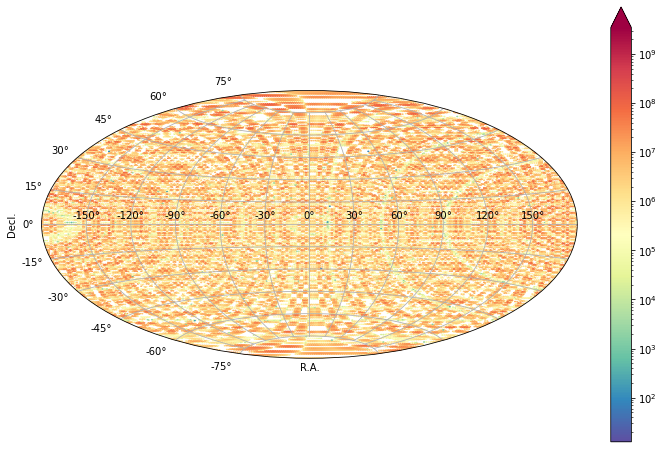

In [4]:

fig = plt.figure(figsize=(12, 8))
fig.add_subplot(111, projection='aitoff')
ra= dfthetaphi.ra
dec = dfthetaphi.dec
color_map = plt.cm.Spectral_r
image = plt.hexbin(ra, dec,dfthetaphi.density*1e14, cmap=color_map,
                   gridsize=500, mincnt=1, bins="log")

plt.xlabel('R.A.')
plt.ylabel('Decl.')
plt.grid(True)
plt.colorbar(image, spacing='uniform', extend='max')
plt.savefig(imgAddress + "G_Decay{}_{}_{}_{}_{}_{}_{}.png".format(a1,a2,a3,N,nx,ny,nz), dpi=300)
plt.show()

In [ ]:
def PhaseX(phase0, x, n, a1):
    a = 0
    x=(x-a1)*2/np.pi
    for j in range(1, n):
        i = j + 180
        a += np.cos(i * x) * np.sin(i * phase0) * filter(i, 4, 0.15)
    return a / n

def filter(i, n, b=0.0001):
    if n == 0:
        return i / (100 + i)
    if n == 1:
        return 1
    if n == 2:
        return np.exp(-b * (i - 100) ** 2)
    if n == 3:
        return np.sin(b * i) ** 2 / i ** 2
    if n == 4:
        return np.exp(-b * i)

    

    
def getSphericalXYZ(n=100,m=100):
    theta = np.linspace(0,np.pi,n)
    phi = np.linspace(0,2*np.pi,m)
    z= np.cos(phi)
    y=np.sin(phi)*np.sin(theta)
    x=np.sin(phi)*np.cos(theta)
    return theta, phi, x, y, z
    
N = 1000
a1=4
a2=2.5
a3=1.33
n=15
phase0=0.25

theta, phi, x, y, z = getSphericalXYZ(N,N)
    
x=np.linspace(-np.pi,np.pi, N)
y= PhaseX(phase0, x, n, a1)
plt.scatter(x=x, y=y, marker=".")
plt.xlim(-1,1)
plt.ylim(-1E-12,1E-12)
plt.show()

In [ ]:
y= PhaseX(phase0, x, n, a2)
plt.scatter(x=x, y=y, marker=".")
plt.xlim(-1,1)
plt.ylim(-1E-12,1E-12)
plt.show()

In [ ]:
y= PhaseX(phase0, x, n, a3)
plt.scatter(x=x, y=y, marker=".")
plt.xlim(-1,1)
plt.ylim(-1E-12,1E-12)
plt.show()

In [ ]:
df.columns

In [ ]:
# We check the orthogonality of the spherical harmonics:
# Si (l,m) =! (l',m') the inner product must be zero
Y = lambda l, m, theta, phi: sp.sph_harm(m, l, phi, theta)
f = lambda theta, phi: Y(4,3,theta, phi) 
g = lambda theta, phi: Y(4,2,theta, phi) 
dotprod(f,g)

In [ ]:
# And, if (l,m) = (l',m') the inner product is one.
f = lambda theta, phi: Y(4,3,theta, phi) 
g = lambda theta, phi: Y(4,3,theta, phi) 
dotprod(f,g)

In [ ]:
n = 500
df = pd.DataFrame({
    'coord_x': np.random.uniform(-3, 3, size=n),
    'coord_y': np.random.uniform(30, 50, size=n),
    'observations': np.random.randint(1,5, size=n)
    })
ax = df.plot.hexbin(x='coord_x',
                    y='coord_y',
                    C='observations',
                    reduce_C_function=np.sum,
                    gridsize=10,
                    cmap="viridis")

In [ ]:
# fig = plt.figure(figsize=(12, 8))
# fig.add_subplot(111, projection='aitoff')
# ax = dfthetaphi.plot.hexbin(x='dec',
#                     y='ra',
#                     C='density',
#                     reduce_C_function=np.sum,
#                     gridsize=100,
#                     cmap="viridis")

In [ ]:
from PIL import Image
import numpy as np

w, h = 512, 512
data = np.zeros((h, w, 3), dtype=np.uint8)
data[0:256, 0:256] = [255, 0, 0] # red patch in upper left
img = Image.fromarray(data, 'RGB')
img.save('my.png')
img.show()

In [ ]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
newcolors[:25, :] = pink
newcmp = ListedColormap(newcolors)


def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

plot_examples([viridis, newcmp])

In [ ]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
newcolors[:25, :] = pink
newcmp = ListedColormap(newcolors)


def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = dfthetaphi[["dec","ra"]]

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

# plot_examples([viridis, dfthetaphi.density])

In [ ]:
import healpy as hp
import numpy as np
NSIDE = 1024
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)
NPIX = hp.nside2npix(NSIDE)
print(NPIX)


In [ ]:
m = np.arange(NPIX)
hp.mollview(m, title="Mollview image RING")
hp.graticule()

In [ ]:

vec = hp.ang2vec(np.pi / 2, np.pi * 3 / 4)
print(vec)

In [ ]:
ipix_disc = hp.query_disc(nside=32, vec=vec, radius=np.radians(10))

In [ ]:
m = np.arange(NPIX)
m[ipix_disc] = m.max()
hp.mollview(m, title="Mollview image RING")

In [ ]:
theta, phi = np.degrees(hp.pix2ang(nside=32, ipix=[0, 1, 2, 3, 4]))

In [ ]:
theta

In [ ]:
phi

In [ ]:
m = np.arange(NPIX)
hp.mollview(m, nest=True, title="Mollview image NESTED")

In [ ]:
# wmap_map_I = hp.read_map("wmap_band_iqumap_r9_7yr_W_v4.fits")
wmap_map_I = hp.read_map("wmap_temperature_analysis_mask_r9_7yr_v4.fits")
hp.write_map("my_map.fits", wmap_map_I, overwrite=True)

In [ ]:
hp.mollview(
    wmap_map_I,
    coord=["G", "E"],
    title="Histogram equalized Ecliptic",
    unit="mK",
    norm="hist",
    min=-1,
    max=1,
)
hp.graticule()

In [ ]:
hp.gnomview(wmap_map_I, rot=[0, 0.3], title="GnomView", unit="mK", format="%.2g")

In [ ]:
hp.orthview(
    wmap_map_I,
    coord=["G", "E"],
    title="Histogram equalized Ecliptic",
    unit="mK",
    norm="hist",
    min=-1,
    max=1,
)
hp.graticule()

In [ ]:
gal="./wmap_temperature_analysis_mask_r9_7yr_v4.fits"
mask = hp.read_map(gal)
wmap_map_I_masked = hp.ma(wmap_map_I)
wmap_map_I_masked.mask = np.logical_not(mask)

In [ ]:
# Before you start plotting data lets create a nice cmap
cmap = cm.RdBu_r
cmap.set_under("w")
cmapseismic = cm.seismic
cmapseismic.set_under("w")

In [ ]:
# planck_IQU_SMICA= hp.read_map("./Data SupernovaLBLgov/COM_CMB_IQU-smica-nosz_2048_R3.00_full.fits")
planck_IQU_SMICA= hp.read_map("./Data SupernovaLBLgov/COM_CMB_IQU-smica_2048_R3.00_full.fits")
planck_IQU_COM= hp.read_map("./Data SupernovaLBLgov/COM_CMB_IQU-commander_2048_R3.00_full.fits")
planck_IQU_NILC= hp.read_map("./Data SupernovaLBLgov/COM_CMB_IQU-nilc_2048_R3.00_full.fits")
# planck_IQU_SMICA= hp.read_map("./Data SupernovaLBLgov/COM_CMB_IQU-smica_1024_R2.02_full.fits")

In [ ]:
fig = plt.figure(1)
hp.mollview(planck_IQU_SMICA, min=-0.0003, max=+0.0003,title="Planck Temperature Map", fig=1, unit="K", cmap=cm.RdBu_r)
hp.graticule()

In [ ]:
from astropy.io import fits

def read_nobs_pyfits(filename):
    with fits.open(filename, memmap=True) as hdul:
        data = (hdul[1].data)
        return np.shape(data)[0], hdul[1].columns.names
    
nObs, cols = read_nobs_pyfits(gal)

In [ ]:
nObs, cols

In [ ]:
hdul = fits.open(gal, memmap=True) 

In [ ]:
len(hdul[1].data)/1024

In [ ]:
hdul[0].__dict__

In [ ]:

from scipy.stats import norm
import matplotlib.mlab as mlab
(mu, sigma) = norm.fit(planck_IQU_SMICA)
fig, ax = plt.subplots()
n, bins, patch = plt.hist(planck_IQU_SMICA, 600, density=1, facecolor="r", alpha=0.25)
y = norm.pdf(bins, mu,sigma)
plt.plot(bins,y)
plt.xlim(-0.0005,0.0005)
plt.xlabel("Temperature/K")
plt.ylabel("Frequency")
plt.title(r"Histogram of $12-N_{side}^2$ pixels from the Planck SMICA Map ", y=1.08)
plt.show()

In [ ]:
cp=camb.model.CAMBparams()
TO=2.725
H0=71
cp.set_cosmology(TCMB=TO, H0=H0)
cp.set_for_lmax(2600)
cp.InitPower.set_params()

In [ ]:
cp.validate()

In [ ]:
results = camb.get_results(cp)

In [ ]:
powers = results.get_cmb_power_spectra()

In [ ]:
for name in powers: print(name)

In [ ]:
planck_theory_cl = np.loadtxt("./Data SupernovaLBLgov/COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt")
totCL=powers['total']
tOeq= TO**2
totCL=tOeq*totCL
totCL=totCL*1E12
print(totCL.shape)


In [ ]:
# planck_theory_cl
powers["total"][:,0]

In [ ]:
plt.rcParams.update({'font.size':14})
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(3,1, figsize=[12,20])
ax[0].set_xlabel('$l$')
ax[0].set_ylabel('$l(l+1)C_l/2$')
ax[0].plot(planck_theory_cl[:,0],planck_theory_cl[:,1], "-r", label="Planck Best Fit")
ax[0].plot(ls,totCL[:,0], "-k", label="CAMB test")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].legend(loc="lower left")
ax[0].set_title("$TT$")

ax[1].plot(ls,totCL[:,1], "-k")
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$l(l+1)C_l/2$')
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_title("$EE$")

ax[2].plot(ls,totCL[:,3], "-k")
ax[2].set_xlabel('$l$')
ax[2].set_ylabel('$l(l+1)C_l/2$')
ax[2].set_xscale("log")
ax[2].set_title("$TE$")

for ax0 in ax.reshape(-1):ax0.set_xlim(2.2500)

In [ ]:
theta, phi, x, y, z = getSphericalXYZ()
l=0; m=0
fcolors = sp.sph_harm(m,l, theta, phi).real
plot_harmonics(fcolors, x, y, z)

In [ ]:
plot_l(2)

In [ ]:
plot_l(3)

In [ ]:
plot_l(4)

In [ ]:
ls= np.arange(1024)
beam_arcmin = 30.0
import math

def B_l(beam_arcmin, ls):
    theta_fwhm = ((beam_arcmin/60.0)/180)*math.pi
    theta_s = theta_fwhm/(math.sqrt(8*math.log(2)))
    return np.exp(-2*(ls+0.5)**2*(math.sin(theta_s/2.0))**2)

fig, ax = plt.subplots(1,1, figsize=[10,10])
ax.plot(ls, B_l(beam_arcmin, ls), color="k")
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$B_\ell(\theta_s)$')
ax.set_title(r"Beam Window Function for $\theta_{FWHM}$ of 30'" )






In [ ]:
white_noise = np.ma.asarray(np.random.normal(0,0.0001, 12*1024**2))

In [ ]:
fig = plt.figure()
hp.mollview(white_noise, min=-0.0005, max=0.0005, title="White Noise Map", fig=1, unit=r'Temperature/K', cmap=cmap)

In [ ]:
plt.hist(white_noise, bins=np.arange(-0.0005,0.0005, 0.00002), color='b', alpha=0.2 )
plt.xlim(-0.0005, 0.0005)
plt.xlabel("temperature/K")
plt.ylabel('Frequency')
plt.title("Histogram of $12N_(side)^2$ random sampels from a normal (Gaussian) distribution ")

In [ ]:

(mu,sigma) = norm.fit(planck_IQU_SMICA)
n, bins, patches = plt.hist(planck_IQU_SMICA, 600, density=1, facecolor='r', alpha=0.25)
y = norm.pdf(bins, mu, sigma)
l=plt.plot(bins, y, 'r--', linewidth= 2)
plt.xlim(-0.0004,0.0004)
n, bins, patches = plt.hist(white_noise, 600, density=1, facecolor='b', alpha=0.25)

In [ ]:
fig = plt.figure(1, figsize=[12,12])
hp.mollview(planck_IQU_SMICA, min=-0.0004, max=+0.0004,title="Planck Temperature Map", fig=1, unit="K", cmap=cm.RdBu_r)

In [ ]:
cl_SMICA = hp.anafast(planck_IQU_SMICA, lmax=1024)
cl_COM = hp.anafast(planck_IQU_COM, lmax=1024)
cl_NILC = hp.anafast(planck_IQU_NILC, lmax=1024)
ell = np.arange(len(cl_SMICA))

In [ ]:
pl = hp.sphtfunc.pixwin(1024)

In [ ]:
# Deconvolve the beam and the pixel window function
dl_SMICA = cl_SMICA/(B_l(10.0, ell)**2*pl[0:1025]**2)
dl_COM = cl_COM/(B_l(10.0, ell)**2*pl[0:1025]**2)
dl_NILC = cl_NILC/(B_l(10.0, ell)**2*pl[0:1025]**2)

dl_SMICA = (ell*(ell+1)* dl_SMICA/(2*math.pi))/1E-12
dl_COM = (ell*(ell+1)* dl_COM/(2*math.pi))/1E-12
dl_NILC = (ell*(ell+1)* dl_NILC/(2*math.pi))/1E-12

In [ ]:
cl_white = hp.anafast(white_noise, lmax=1024)
dl_white = (ell*(ell+1)* cl_white/(2*math.pi))/1E-12

In [ ]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111)
ax.scatter(ell, dl_SMICA,
          s=4, c='black', lw=0, label = "SMICA")
ax.scatter(ell, dl_COM,
          s=4, c='blue', lw=0, label = "COM")
ax.scatter(ell, dl_NILC,
          s=4, c='green', lw=0, label = "NILC")
ax.scatter(ell, dl_white,
          s=4, c='grey', lw=0, label = "White Noise")
ax.set_xlabel("$ell(ell+1)C_ell/2\pi \, \,(\mu K^2)$")

ax.plot(planck_theory_cl[:,0], planck_theory_cl[:,1], '-r', label="Theory")

ax.set_ylabel('$\ell$')
ax.set_title("Angular Power Spectra")
ax.legend(loc="upper right")
# ax.set_yscale("log")
ax.set_xlim(2,1024)
ax.set_ylim(2,7000)
ax.grid()